# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [37]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [38]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [39]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=(2**16),alternate_sign=False, ngram_range = (1,2))
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['exclaim_count'] = toxic_data["comment_text"].str.count("\!")

    X_quant_features = toxic_data[["word_count", "punc_count", "exclaim_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [40]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_train.csv', my_random_seed=95)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [41]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 6592, 'TN': 57106, 'FP': 57548, 'FN': 6410, 'Accuracy': 0.49898163815253493, 'Precision': 0.10277517929529155, 'Recall': 0.5069989232425781, 'desc': 'ols_train'}


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


### MODEL: SVM, linear

In [42]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12974, 'TN': 114630, 'FP': 24, 'FN': 28, 'Accuracy': 0.9995926552610139, 'Precision': 0.9981535620864749, 'Recall': 0.9978464851561298, 'desc': 'svm_train'}


### MODEL: logistic regression

In [43]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12989, 'TN': 114632, 'FP': 22, 'FN': 13, 'Accuracy': 0.9997258256564517, 'Precision': 0.9983091230497272, 'Recall': 0.9990001538224889, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [44]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12196, 'TN': 106283, 'FP': 8371, 'FN': 806, 'Accuracy': 0.9281114871216394, 'Precision': 0.5929887684154228, 'Recall': 0.9380095369943086, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [45]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12978, 'TN': 114635, 'FP': 19, 'FN': 24, 'Accuracy': 0.9996631572350693, 'Precision': 0.9985381241825037, 'Recall': 0.9981541301338256, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [46]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 12576, 'TN': 114605, 'FP': 49, 'FN': 426, 'Accuracy': 0.9962790624804161, 'Precision': 0.9961188118811881, 'Recall': 0.9672358098754038, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 13002, 'Neg': 114654, 'TP': 0, 'TN': 114654, 'FP': 0, 'FN': 13002, 'Accuracy': 0.8981481481481481, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/isabelstoddart/Desktop/ML/myWork/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

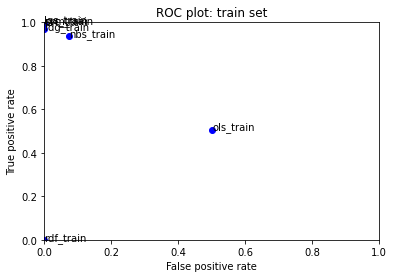

In [48]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: train set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [49]:
ols_predictions = ols.predict(X_train)

In [50]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
8
I didn't do it 

I didn't add improperly cited content to Wikipedia like List of Little Einsteins episodes.
* * * * * * * * * 
139
I declare that Zanhe stop undoing my edits. If Zanhe continues, he will be blocked from any more editing!
* * * * * * * * * 
141
The Additional Material section only has info for Cloud's DLC costume, but not Lightning's. 142.26.194.190
* * * * * * * * * 
199
Well is guess wikipedia is now liable pursuant to EU laws so we will soon now who you are, you cant hide behide wiki
* * * * * * * * * 
390
Charles Curtis
I find it interesting that there was a minor controversy over Goldwater's nomination due to having been born in Arizona Territory since Vice President Charles Curtis was born in Kansas Territory in 1860, one year before statehood.
* * * * * * * * * 
465
What Roydosan points out is elementary to anyone who has even read just one basic scholarly work on The Roman Empire, that is, the Universalism (even before the Constitut

3098
Glaring evidentiary deficiency not reported herein wrt George Zimmerman's account of events 

Recent photos of Zimmerman shortly after the shooting made by the police show no blood spatter on his front including his shirt.  His account claims that Martin was directly over him when he shot him.  Yet a 9mm hollow point wound in Martin's front chest would be expected to shower blood all over Zimmerman.  This evidence clearly contradicts Zimmerman's account.  Another report indicates that the shot was fired from more than 18 inches away.  This contrary evidence and contradiction in Zimmerman's story should be noted in this wiki article.  Speculation is that Zimmerman achieved standing (off the ground from a lying down position) status after Martin's struggled with him and then shot him with his 9mm as payback for the beating upon himself which he had apparently initiated.  By leaving these facts out of the article it suggests that wiki authors are suspedning the laws of gravity and co

5675
I don't wonder at all, and many have agreed that it doesn't belong here. That is why I've respectfully removed your edit. There is a link to the proper place for sex ed on wikipedia.
* * * * * * * * * 
5720
Richard Pombo 

Thanks for catching the massive deletions by 75.25.46.157 to the article (his/her only edits to date). I do wonder if they were actually done by
* * * * * * * * * 
5727
"

Relaunching WikiProject Pittsburgh meetups
You are receiving this message because you are a member of the WikiProject Pittsburgh. In the past we have discussed a meetup idea - let's see if we can make it a reality during the summer. Please see this thread for more information.| talk  "
* * * * * * * * * 
5749
"
Sounds good.    ♦ ♣ ♠ "
* * * * * * * * * 
5829
"

 Guinness 

Hi. I found you in the WikiProject Ireland. I'm currently mediating a case here about Guinness. Can you please go there and give your opinion? Those involve want a comment from someone knowledgeable with Irish matters. Thank

8290
Revisionist History 

Not sure what all this Joel Campbell / NASA 399 / Langley / impersonation business is - seems irrelevant. Nevertheless, somewhere in the middle of it all, an important sourced fact - that Dannenberg was a Nazi party member - was deleted. Not only was this sourced from the Wall Street Journal, but is an extremely important point as it was under the Nazi regime that Dannenberg made his name as a rocket engineer. The removal of this fact suggests some disturbing revisionist history going on. Perhaps a moderator could watch this page to ensure there is no neo-Nazi interference with established history? Thank you.
* * * * * * * * * 
8310
"
True, but with the right ultrasound (one of each), maybe they'd speed up finalizing the intended changes, instead of pretending they've already gone into effect ) -  "
* * * * * * * * * 
8390
Feel free to let the WP census determine it, and to do that you're supposed to use the articles talk page here, and especially so in this 

11135
"
I just have one thing to say in my defence before I take Upstater's advice and let things slide from now on. Hippo can wikihound me, Hippo can call my editing ""crap"" at AN/I, insult opinions and editing and comments various times, and call another user's opinion ""moronic""  "
* * * * * * * * * 
11146
List of UEFA club tournament winning managers 

Hi Peanut, just wondered if you could spare five minutes (or more!) reviewing the above, it's sat at FLC for several days no without comment and I'd like to push it on a bit.  Hope you're having a good Easter, all the best,
* * * * * * * * * 
11158
"

Removed, but funny enough to memorialize in the talk page

             This disease is also called a 3rd knee, a nob or ""splaggies"".  "
* * * * * * * * * 
11212
"
 Sarek claimed that it was in place and was asked for the diff by Domer, I asked him/her too and they said it was there it appears now it wasn't as can be seen here. Talk "
* * * * * * * * * 
11239
"

@""There is no way o

14147
right i cant email you for some weird reason i cant work out so i hope you can see this. if this is about first commet on global wrming page, could you please explain which editor i attacked and for bieng of which nationality. and ill just clarify that my comment was not condoning anyones personal attack, i couldnt actually see any, it was to make the point that nazi is not a horrible diry word and it can be used to describe people who are restraing others personal freedom however slightly.
* * * * * * * * * 
14303
Albeit on an Explorer, (taken out of its frameset) shows a Meadows 10.3 litre petrol engine.  Some research is needed by an enthusiast, here, to determine what was fitted to the Pioneer.
* * * * * * * * * 
14370
"

 edit warring 

Hello Rm125, you are continuing to edit war at Aftonbladet-Israel controversy. You just made your 4th revert. Please do not continue doing so or you may be blocked. Thanks, '''''' - "
* * * * * * * * * 
14408
I would note that searching for P

16967
Truth hurts, I take it.
* * * * * * * * * 
17035
its true! i went on to a pokemon website that said its english name is floattoon!
* * * * * * * * * 
17047
"

 Use of Person infobox  

Don't hardcode the ages of people into their infoboxes. Every single one of the many infoboxes you have done this to will now have to be updated every year. That's why we have Template:Birth date and age. Please go back and use it on all of the infoboxes where you added an age.
Similarly, read Template:Infobox person to see how to use the person info box and the allowed field. You will note that ""residence"" is not spelled ""residencse"" as you have done. Please go back and fix all of the infoboxes where you made that mistake.   "
* * * * * * * * * 
17068
Template replacement articles 

Without anyone mentioning it to me 1929 world leaders was prod'd and deleted. I've restored it. Does anyone have a better idea? I thought this served well as a centralized clearing house for the three related artic

19540
This is a wonderful resource. I'm from karachi and I think starting neighbourhood pages is a good idea. I'll try to contribute towards this article very soon. Again, great work guys!
* * * * * * * * * 
19616
Hey. how about the preceding section? hehe. Are you not busy?
* * * * * * * * * 
19656
How come they can gripe about me all the time for spurious reasons that are not block-worthy but when I do it once I am blocked? This makes no sense at all, there is a massive double standard in how they are treated as compared to how I am being treated. You are a hypocrite with a massive chip on your shoulder. Your hatred of me is your motivation here, not any sense of justice. I am sick of this vendetta. You need to stay away from me.
* * * * * * * * * 
19707
There is no need to do that, the source given above speaks explicitly about the cases of the European Court of Human Rights where the occupation of Baltic states has been under discussion. And that's what this article is about.
* * *

22053
Ok. I'll continue to take Semitic to mean Jewish and require other uses to be fully defined by their authors. (I know some Arabs are Jews; the cab driver was not.) I wonder - it's not a matter of misuse, per se; is it not more a matter of ambiguousness?. Anyway, if you don't think a distinction should be made...well, I'll just carry on as before.
* * * * * * * * * 
22068
"

 Your GA nomination of The Boat Race 1967
The article The Boat Race 1967 you nominated as a good article has passed ; see Talk:The Boat Race 1967 for comments about the article. Well done! If the article has not already been on the main page as an ""In the news"" or ""Did you know"" item, you can nominate it to appear in Did you know.  (talk) (cont) "
* * * * * * * * * 
22073
Can you walk me step by step through that process. Assume I know nothing.
* * * * * * * * * 
22093
Image copyright problem with Image:Stella Hudgens, 10.jpg

Thank you for uploading Image:Stella Hudgens, 10.jpg. However, it currently is m

24530
my comments in on the arbitration request he filled out.
* * * * * * * * * 
24532
"

 Medcan posting 

Can you please explain why you re-posted the information on the Danish Meta Study?  Your last message asked the 2 parties to reach out and discuss this to come to a conclusion.

Your information about the Danish Meta Study should not be on our page, it should be posted on the ""physical examination"" page.

I am going to remove this until you engage in a proper dialogue on why it should be posted on our Wikipedia listing.  You are publicly refuting and slandering the ideals of our business on a medium where you have no right to.  Wikipedia is about facts - the Danish meta study is not factual - ""casts doubt"" is used in the explanation.  That means they aren't certain that physical examinations are useful.

Please stop trying to police Wikipedia, and let facts be facts."
* * * * * * * * * 
24574
"

 What page? And when is 12 m used? 

Hi Hi Lo48, I know the discussion is closed

26970
"

Speedy deletion of D-dot-z
 A tag has been placed on D-dot-z, requesting that it be speedily deleted from Wikipedia per CSD G1. 

Under the criteria for speedy deletion, articles that do not meet basic Wikipedia criteria may be deleted at any time. Please see the guidelines for what is generally accepted as an appropriate article, and if you can indicate why the subject of this article is appropriate, you may contest the tagging. To do this, add  on the top of the article and leave a note on the article's talk page explaining your position. Please do not remove the speedy deletion tag yourself, but don't hesitate to add information to the article that would confirm its subject's notability under the guidelines. 

If you think that this notice was placed here in error, you may contest the deletion. To do this, add  on the top of the page (just below the existing speedy deletion or ""db"" tag) and leave a note on the page's talk page explaining your position. Please do not remov

29551
come on, that's not harrassment. just an agument. 113.111.204.167
* * * * * * * * * 
29582
I concur with Mozart20d.  He took the words right out of my mouth (literally, we had an edit conflict, and I somehow lost my post).
* * * * * * * * * 
29601
Life 

Do you have anything better to do?
* * * * * * * * * 
29608
"

Disputed fair use rationale for Image:Fembot 3 APTSWSM.jpg
Thank you for uploading Image:Fembot 3 APTSWSM.jpg. However, there is a concern that the rationale provided for using this image under ""fair use"" may not meet the criteria required by Wikipedia:Non-free content.  This can be corrected by going to the image description page and add or clarify the reason why the image qualifies for fair use. Adding and completing one of the templates available from Wikipedia:Fair use rationale guideline is an easy way to ensure that your image is in compliance with Wikipedia policy. Please be aware that a fair use rationale is not the same as an image copyright tag; descriptio

Please do not replace Wikipedia pages with blank content. Blank pages are harmful to Wikipedia because they have a tendency to confuse readers. If it is a duplicate article, please redirect it to an appropriate existing page. If the page has been vandalised, please revert it to the last legitimate version. If you feel that the content of a page is inappropriate, please edit the page and replace it with appropriate content. If you believe there is no hope for the page, please see the deletion policy for how to proceed.
* * * * * * * * * 
31525
A tag has been placed on Sukip, requesting that it be speedily deleted from Wikipedia. This has been done because it is an article about a certain website, blog, forum, or other web content that does not assert the importance or significance of that web location. Please read our criteria for speedy deletion, particularly item 7 under Articles, as well as notability guidelines for websites. Please note that articles must be on notable subjects and 

33650
us before any more of the sort of edits you’ve been making on CAD-related articles this week
* * * * * * * * * 
33709
common sense. bite me. -steve
* * * * * * * * * 
33713
Important notice 

The actions that you have taken on List of Tetris variants are enough cause to press charges and that is exactly what our lawyer is doing right now.  Your actions violate approximately 6 international laws, and carry fines of as much as $250,000.  Our lawyer will contact you shortly, to announce the date/time of the scheduled court meeting.  You will be summoned to this meeting, and if you do not show up, you will be arrested and will waive your right to a jury trial.  This is a very serious issue, and I advise you that any statement you make can and will be used against you in a court of law.
* * * * * * * * * 
33781
Advert and inadequate sources 

Article appears to be an advertisement for the book... her association with the conspirators is placed in sentence 1, the article rhapsodizes on

36216
Welcome!

Hello, , and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page
How to write a great article
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on , or ask your question on this page and then place {{helpme}} before the question. Again, welcome! 

Edits to New Jersey Devils
Hi! I just wanted to mention that I removed the commentary on games 1 and 2 of this years playoffs from the main New Jersey Devils article, as it goes into a little too much detail for that article.  However, the season article, 2008–09 New Jersey Devils season requires a great deal of prose and commentary, and would be far more suitable for e

38596
"

 RE: Your Message  

It maybe fun in your mind but for most its not, your just disrupting people who use the website to gain information and its up to users like me to clean up your mess. And i did not ban your mate, i dont have the power to do that and you probably might want to look here to see why certain users are blocked and cant edit anymore. Thanks '''''''''' (talk 2 me) "
* * * * * * * * * 
38654
"

You made an identical post on Talk:History of the aircraft carrier, I have replied here, I don't intend to repeat myself. -  talk "
* * * * * * * * * 
38660
Talk How about you rad tyhe rules for unsiurced materal and explain, why you keep putting unsourced material in articles in breach of the rules?203.192.91.4
* * * * * * * * * 
38782
Copied section and lack of sources
Several sections have been copied verbatim from http://murderpedia.org/male.B/b/bishop-william-bradford.htm
Additionally, there is no other source for the rather unrealistic claim that the idiom'put someone

41325
"

 Blocking Mardyks (2012) 

Excellent work there Shii. We can't have his kind getting us to think about what the Maya actually say about their own prophecies. We insulted him, offended him and abused him and he just had to be ethical and persistant. BLOCK those Mother Fukkers!!! Taking out the entire Santa Fe Public Library system is a great preemptive strike also. There may be others of his kind, that sympathize with those ""Indians"". These people actually LOVE the Earth and that is without reliable sources! We kicked their asses and have the right to write THEIR history and interpret THEIR sacred teachings however we please. We need more from college students who have been indoctrinated in the Church of Academia. That piece by Stitler is one of the most exaggerated and opinionated and so yeah, use that as the title of the page! And by all means give John MAJOR Jenkins his own section. Not a single scholar or Mayanists agrees with his appropriated theory and this kind of hypo

44115
Somehow, I should have been notified of that discussion, Minderbinder.
* * * * * * * * * 
44141
Minor edits by User:John Kenney need to be rewoven. 

Sorry about rolling back...However, my edits are equally valid to yours.
* * * * * * * * * 
44188
I see, the way it is said on the page places the onus on women. I will change it to make it gender-neutral.
* * * * * * * * * 
44223
"

 ""Andre Driver"" 

I seriously doubt Andre's Tombstone Piledriver was ever called this. I nor anyone else I know of has heard it called this. Whoever keeps adding it, just give up. It'll never stick without an audio/video source. Some site like OWW isn't reliable."
* * * * * * * * * 
44285
Bal 537's edits 
You are here in Wikipedia just to misguide readers with your eccentric views and false idiology.

The marriage of Sikhs, Budhist and Jains are covered under Hindu Marriage Act. This doesnt mean Jains are Sikhs or Sikhs are Budhist.

Stop misguiding world with your false information.
* * * * * * * * *

46670
"
That is a very good strategy, .  Let's discuss it "
* * * * * * * * * 
46694
Support per nom. I agree that isn't really a primary topic here and would support having the disambiguation page at Alexander.
* * * * * * * * * 
46855
So if your doing a correspondance in R^2 how would you sketch G(x) = {y is an element of R^2 such that the dot product of x and y is 0} if G(3,4)
* * * * * * * * * 
46880
"

 Greetings from the Opera Project again 

Hi, Satyr.  You'll remember that you and your bot did some excellent work for us (on the Wagner sub-project) a few months ago.  How are you fixed at present?  We'd like to dip a bigger toe in the assessment process by automatically giving a ""Start"" rating to those articles that are tagged with the Opera Project banner and are not already classified as Stub.

Exceptions:  articles which have been promoted to Good Article, Featured Article or Featured List should show those ratings on the banner.  Also, it would be good if any articles which

49208
RE: Barnstar 

Thank-you very much for the barnstar! Have an excellent day.  (Chat)
* * * * * * * * * 
49214
since they figure in Caesar's Gallic War
* * * * * * * * * 
49237
Improper interference (Byzantine Empire) 

Unless you are willing to make a useful input to a discussion please do not de facto continue edit wars on someone else's behalf. My minor edit was not sibject to consensus since it was merely an attempt to return questionable wording to a neutrality. Thousands of articles in Wikipedia contain errors, grammatical, factual or just plain misprints. The fact that they persist for long periods doesn't make them a product of consensus, an actual discussion does.
* * * * * * * * * 
49261
"

 Russian Ship Names 

Hello. Thank you for your reply to my question.

Yes, the ship names I already have were Mir and Nadezhda, and I was hoping for more such words. Nadezhda, by the way, is apparently a female name and the name of a few Russian warships. I don't require them to be na

51771
UNBLOCK SHANNON! ===     === UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON! 
 UNBLOCK SHANNON

54391
I second that.  I don't know much about Staley or Alice in Chains; otherwise I'd do it myself.
* * * * * * * * * 
54460
"::The less offensive term of equal clarity and brevity is ""British & Irish Isles"". Believe when I say that the Manx natives have no trouble with this description as they are linked to the U.K. as a protected and supported territory, Republic of Ireland on the other hand is a sovereign nation with no link to the U.K.

The basis for usage of the term is completely flawed logic as it refers to ancient texts etc and precedent for calling them the British isles. Place names reflect current realities, thus we have Istanbul and not Constantinople.

A better example would be the Aegean coast of Turkey and its islands. this whole area was once referred to as the Greek coast and all the islands were Greek islands. since the political landscape has changed and the Turkish state has jurisdiction, the only islands which are now ""Greek islands"" are those within the juris

57026
Charles Sumner article 

Hello Dr. Jensen. I have recently been making edits on the Charles Sumner article.  I have expanded on the Dominican Republic annexation treaty and information on President Grant.  Are there any other areas that need work on the CS article?
* * * * * * * * * 
57035
Why was the edit war starter has to be me, you're another hypocrite
The talk page at maldivian language got vandalised and deleted many times by by User_talk:Kwamikagam now you're accusing me of edit warring? what kind of a admin are you? Also User_talk:Kwamikagam thinks he owns the wikipedia and everything in the world to rule however User_talk:Kwamikagam what's. I'm just a guy from maldivians trying to contribute the native language of mine but some chinese hypocrite here is vandalising the whole wikipedia and he has also previous vandalism of other language these kind of users shouldn't be allowed in wikipedia, you're doing the opposite as a administrator of Wikipedia, you're taking the wron

59762
"

I think that it should be included as I had included, that's it, as part of Biafra (only during some time in 1967). What is not logic is to not include the Re. of Benin but put a Rep. of Benin flag next to Albert Okonkwo at the infobox. Or Rep. of Benin had to be included or the flag next to Albert Okonkwo had to be changed to a Biafra one. Also, Im gonna add ""citation needed"" to all the supposedly supporter countries with no sources. Regards,  "
* * * * * * * * * 
59787
"
Typically, when Xenophrenic sees a valid edit (by wiki policy) that he disapproves of (for whatever reason), he seeks to get others to remove it. This strategy is quite effective as he says the edit needs balance, or needs the proper context, or isn't the full story, etc. There are many different reasons used, but the end result is him adding so much trivial nonsense ( > 2 to 1 ratio in his POV) that average editors cringe when they see it. Xenophrenic then declares that the original unbalanced POV version

62358
"

 David Yates and Harry Potter film series 

Hello. ) I was reading the Harry Potter (film series) talk page and there was a discussion about nominating it for GA status. Well, I am more than willing to have a bash at resolving the reference formatting problem. On the topic of GA, I have nominated the David Yates article and all I need now is for someone to review it. Would you be willing to take a look at the article to see if its any good and, if you think it is, would it be possible for you to have a go at reviewing it (it should be in the Theatre, Film and Drama section)? That's if you have time of course. I am not permitted to review the article because I have worked on it for some time. I am desperate to get this into GA status as I think it's a good looking article. If you can't help, no worries. Thanks. )  "
* * * * * * * * * 
62374
Copyright ===

  

===
* * * * * * * * * 
62511
"

I can see it, but how about other users? OK, i think field hockey is differ to football,

65367
does anyone live here like me?
* * * * * * * * * 
65389
Chris Brown 

Stop saying Chris Brown is dead. You know he isn't. Stop hatin' on him.
* * * * * * * * * 
65454
"

 Presumably only someone born in 1971 (Ben Zimmer) can consider 1975 to be ancient history?
 It seems everyone has lost interest here but I made an effort to make some sense of this. 
 The article was confusing 3 entirely separate uses of the term, a red line (a line in the sand), a Thin Red Line (a brave and defiant stand against great odds) and to redline (meaning to go beyond an engine's maximum safe performance level). I am sorry to say it, but for someone who claims to be a""lexicographer"" and language editor, Mr Zimmer ought to be ashamed.   "
* * * * * * * * * 
65526
, without losing any real descriptive power
* * * * * * * * * 
65559
Trailers 
Trailers for The Dark knight have been surfacing from god knows where. You Tube has great teaser trailers. You can even see The Joker. But i feel a little dissapoi

68099
Qalat
Is it possible that you could correct any errors yourself, and I note that the article currently doesn't mention that the term is as widespread as you say. I can only work from what is given.
* * * * * * * * * 
68120
World Intellectual Property Organization

World Intellectual Property Organization (WIPO) website
* * * * * * * * * 
68148
"

Where You Gonna Go Soweto
Although this is listed as being written by the Clash in the liner notes of the legacy edition, it is in fact clearly a cover of Sonny Okosun's Fire in Soweto
http://www.youtube.com/watch?v=inCMdSWYKOo
Whether or not Sonny Okuson actually penned the tune I do not know but it certainly should not be attributed to The Clash  —Preceding unsigned comment added by 86.40.31.132   
No assertion can be made without a reference, and a YouTube video is not a reliable source. -''''''The'FortyFive' "
* * * * * * * * * 
68184
This article has gone to hell 

I am tired of the crap from all of you. I am done trying to keep thi

70735
"

 Documentingabuse 

Thatcher,

I would like to ask you how to correct a number of detrimental false impressions that you have left on the Checkuser for Documentingabuse. Excuse me I am still with a dynamic IP address only from the same ISP.

You have stated that I edited whilst logged out. If we look at the actual diffs, you will see that this is not true. I only made the account AFTER editing and so could not have logged in in the first place

60.42.252.205

started - 14:43, 11 June 2008  
end -  21:26, 12 June 2008  
TAB
60.42.252.111

started -   07:02, 14 June 2008  
end - TAB  16:14, 14 June 2008  

222.150.193.35

started -  16:40, 14 June 2008  
end -  17:18, 14 June 2008  

Documentingabuse

created -   17:36, 14 June 2008  
end -   18:26, 14 June 2008  
TAB
I myself added blocked user  and
alleged ""death threat"" canadian editor 

so as to remove them from the excuse being made against me by Rlevse in order to make a ban. 

That has now been resolved with an apology 

73944
Centuryinbox 

I noticed your edit here. Very nice catch. I am going to update AWB's tagger to exclude pages with centuryinbox from being tagged as deadend.
* * * * * * * * * 
73955
"

""Warez - I was involved in the illegal transfer of copyrighted software for a good 15 years.""
""uNITED cRACKING fORCE - a cracking group I was a member of for 5 years.""
""aPOCALYPSE pRODUCTION cREW - a music piracy group I was in for a few years""
 - courtesy of ALKIVAR's home page.  "
* * * * * * * * * 
74019
"
Thanks; see also ""small amount of wikimarkup"".   "
* * * * * * * * * 
74087
(which is already an external link), and this tutorial; I'm not suggesting to transform the article into a manual, but to at least give some practical examples of what, say, processor-independent means (which, by the way, isn't even mentioned here).
* * * * * * * * * 
74162
Yeah, I left a comment back on the reference desk.  (talk • contribs)
* * * * * * * * * 
74186
THIS IS STALKING
I should not have to explai

76925
Hmm, this can probably be enhanced to Freedom of speech = New WikiProject + notification of the whole encyclopedia...
* * * * * * * * * 
76937
"Pronunciation of Ч ==

The current pronunciation is given as ""tɕ"". Is this really the best match for the ""ch"" sound in ""chip""? Would not ""tʃ"" be the right sound? If not, can someone help explain the difference, please? Many thanks!

== "
* * * * * * * * * 
77045
My views? What are trying to imply here? Are you accusing me of revisionism? aina.org is better than nothing. I don't think aina is making this up. The Encyclopaedia of Islam is not necessarily an objective unbiased source. I couldn't find anything about Bahira or whatever his name was, alleging that he was made up by some medieval Christian polemics, in this article: Encyclopaedia of Islam. So give me another one. I'm going to redirect this to Sargis Bahirâ, seems like a more correct naming of this guy. Either way, I hope that we can collaborate on this article without di

79024
Front page 
The frontpage comments that the victim was killed in a carbomb, but since the bomb was placed in a trash can nearby and not in the vehicle perhaps different wording should be used.
* * * * * * * * * 
79046
I don't know where you are really from, but it's not just Germany, it is in the US, UK etc, too. They are arresting children and taking them away from their parents! It's gone too far. And it is mostly because of this friggen movement. Don't you see that?  (talk)
* * * * * * * * * 
79056
"

 Oregon Ducks football 

Hi Abdoozy, sorry for not responding sooner. I've been in somewhat of a hiatus and didn't see your message until today when I went to update the Oregon Ducks track and field page with the recent women's indoor title. I blazed through the article really quick and it looks much better. Some of the ""eyesores"" have been eliminated and it's in general, much cleaner that it was before. I'll take a look at it in more detail when I have the time. Let me know if

81645
Not Manpower, as it said before I fixed it.  What moron thought Manpower is the largest private employer in this country?  LOL.
* * * * * * * * * 
81646
Dear BozMo, regarding the reliability of sources. I have added a few more links (after the second sentence), see . I think it conforms to WP:BLP, but
* * * * * * * * * 
81674
"
 I agree with 132.206.198.36. Another source that testifies to Ibn Sina's Sunnism, based on the Gutas paper mentioned above, is  Janssens asserts that Gutas ""convincingly demonstrates that I.S. was a sunni-Hanafi."". He also gave more details. I see no reason why this view shouldn't be mentioned in the article.   "
* * * * * * * * * 
81743
"

Transclusion Limit this is what the rpoblem with transclusion of the coordinates as well hopefully this ex plain its, i can easily show this problem if the user who wants to see it is on when i m i just need to edit this page http://en.wikipedia.org/wiki/Template:Episode_list/Time_Team to last version i had befor eth

84225
" July 24,2009 ===

The official Constitution of India lists Ramdasia caste as a Chamars. How do you explain that? Here is the link:
.

Castes and Tribes of Punjab by G.W Briggs written in 18th century lists Ramdasia as Chamars. How do you explain that?

A research paper on scheduled castes of Punjab: Showing that Ramdasia's are Chamars

Official Constitution of India: Scheduled Castes Amendment

Please review provided links that proves and validates what I have written. 

Bal537  —Preceding unsigned comment added by  (talk • contribs)  

==="
* * * * * * * * * 
84238
The Smolensk Conference 
Can you complete the information about the Smolensk Conference in the article 2010 Polish Air Force Tu-154 crash ?
* * * * * * * * * 
84290
"
Okay in that case I shall assert that from now all shall refer to me officially as ""Holy golden monkey who brings the sun"", well because obviously what I say my title should be is more important than anything else. talk "
* * * * * * * * * 
84293
All

87075
Pie edit

Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.
* * * * * * * * * 
87078
organization (The Washington Post )
* * * * * * * * * 
87087
Free Imperial City of Cologne  

You'd need to get agreement to do this, and there's a copyvio issue also.
* * * * * * * * * 
87461
mr joustra said protrusion rebels were in charge of the area
* * * * * * * * * 
87504
Duplicate
Hi! If the San Antonio and Brooke Centers are the same, then one should be merged into another. The name currently being used should prevail
* * * * * * * * * 
87519
Go for it! Source it well, by books if poss. Good luck
* * * * * * * * * 
87573
REDIRECT Talk:George H. D. Gossip/GA1
* * * * * * * * * 
87608
I see. And does that fix the date to 1954?
* * * * * * * * * 
87623
Ok, ta. I'll just add it to the Discussion page then to flag it, given his works are now being used as secondary sources by other biographers. Other contributors m

REDIRECT Talk:Paddy Kelly (Cork Gaelic footballer)
* * * * * * * * * 
89751
"

Oppose because in my view, ""lead"" in the context of ""lead paragraph"" is unambiguous. (talk) "
* * * * * * * * * 
89835
I rest my case. Did you get a uniform with this job as well?
* * * * * * * * * 
89876
Good point, I don't expect to see the article deleted so I won't bother.  It's clear that wikipedia is not a truly representative forum and that it has been taken over by hacks, zealots and vandals who have become adminsitrators, largely it would appear (based on Connolly's bio) due to the fact that they don't have productive employment obligations elsewhere.  I, fortunately do have such obligations and expect to be out yelled, screamed, reverted and controlled.  Ultimately however, this will not alter the fact that you are *wrong* in your fundamental philosophy, and this new fascism will ultimately die as the other forms have.  The issue really is how many people will be harmed by these fascists that a

92114
Talk 

I have made my points on my articles.
* * * * * * * * * 
92118
First of all, yes you did man, go look in the history. I can go back and look at who edited the page man, don't lie to me. It should be pretty clear by my responses that I can write too, I actually use better grammar than you on this talk page. And no you're not editing it, let me try to work with it first. I only got involved with this whole mess about an hour ago and I had some things to do first. I'm sorry I got a late start, I actually have a life outside of Wikipedia.
* * * * * * * * * 
92151
"

 Roll call 

If you are actively involved in Wikipedia:WikiProject Dallas-Fort Worth, please add your name here. 110 "
* * * * * * * * * 
92172
You're welcome. And thank you for being gracious. Mmm, the various discussions petering out is not unexpected. With a need to separate the individual from their contribs, and consider together when needed, along with 'meta' discussion of policies themselves, any discussion 

94637
the holocaust museums address is 100 Raoul Wallenberg PL SW Washington DC, 20024. OR 100 15 ST SW DC, hence they are the same street.
* * * * * * * * * 
94664
"
For the record, I never thought you were a bad guy. Like you, I hope something good will come out of the essay and the debates surrounding it; at the very least, I think it has highlighted some problems that should be addressed. I also hope that since the article was moved into ""private"" userspace, the edit wars which were occurring will cease. Best wishes and happy editing,  "
* * * * * * * * * 
94752
. This might be a clue to tone it down
* * * * * * * * * 
94875
"
Ah, thanks for catching that! I guess I should have tried to read the whole thing before tagging it. {{nowrap|' talkcontribs}} 
Yes always worth reading the whole thing. Sometimes everything can seem totally reasonable till you see a final barbed sentence at the end, othertimes a person can seem utterly unnotable until you see a final sentence such as ""bes

97119
You categorized them. Let me have better wording. I thought there may have been two many categories but otherwise it looks fine.
* * * * * * * * * 
97214
Macedonian last names and some common endings of the last names in the Slavic Languages
* * * * * * * * * 
97222
Potential difference is ..... related to the energy that would be required to move a unit of electrical charge from one point to the other against the electrostatic field that is present.  sounds rather similar to emf!
* * * * * * * * * 
97426
"
I apologize, I did not realize ""Texan"" is a profanity. 69.105.172.180  "
* * * * * * * * * 
97452
Your patience with this person is exemplary. Nevertheless I note that she singled you out for criticism at SP talk and has just summarily deleted your totally honest defence (that your response had been to routine attacks on you which had gone unremarked). It seems that when she indulges in responses that appear inappropriate and overly officious, they sometimes also appear to b

99919
Date of birth?
Booking report shows birthdate of 29 April 1967 and middle name of Robert. -  17:23, 3 Feb 2005 (UTC)
* * * * * * * * * 
99963
Hey I'm really glad you liked it! Drawing it was as fun as I expected. And I wish he/she was successful in his/her intentions, to see such a species vanishing would be heartbreaking... Meanwhile, his close brazilian cousin, Eustrombus goliath, may be facing a much worse fate. I'm skeptic about such things in Brazil, and It is hard for me to believe a serious plan of sustainable exploitation of aquatic resources, specially regarding this species, will ever see the light of day. And If by any miracle it does, It will never have proper management and sufficient funds, and so on... I hope I'm wrong about it =(!
* * * * * * * * * 
100015
Support.  Makes sense to me.
* * * * * * * * * 
100022
Finally, must reports that are released from accident investigators have a list of recommendations for changes in training(that is the reason why they have 

102781
"

I have no concerns about his edit, but it is unsourced. I trust this guy, but we may have to wait until his Encyclopedia about Galliformes comes out and totally revises the taxonomy. Pinudjem is his second part of his middle name (Amoun-Pinudjem) of his alternate name (Milad Sourial). If you search for that name on the web you can see that he is making a movie called ""Goddess of the Sun"", not only from the photo gallery concerning the Green Peafowl but also from a site not by him.

Kermit does not have a real name. His real parents gave him a name he didn't like. Sadly, his real parents died in a political assacination. He was then named Kermit Roosevelt by his adoptive parents, but he didn't like that either. He has three user accounts: User:Amoun-Pinudgem (middle name), User:Milad A.P. Sourial, and his newest is User:Pinudjem. However, he has also edited with an IP once, which was reverted. He often writes under Kermit Blackwood and was also quoted in the Red Data Book as

105588
"

 2012 Nehru Cup 

Hello. I few months back you closed an AfD regarding the 2012 Nehru Cup here and the result was redirect till information comes out (dates, format) and yesterday they came out. I asked if the redirect could be undone, which it was and then I added the information. Then   "
* * * * * * * * * 
105691
|-
| Drastamat Kanayan
| M
| 1884-1956
| Politician, revolutionary and general. Lifelong service to the Armenian cause.
| 
|-
| Garegin Njteh
| M
| 1886-1955
| Politician, political thinker, revolutionary and fedayee. Lifelong service to the Armenian cause.
|
* * * * * * * * * 
105692
Suggestion for WikiProject United States to support WikiProject Colorado
It was recently suggested that WikiProject Colorado, to which you are a member, may be inactive or semi-active and it might be beneficial to include it in the list of projects supported by WikiProject United States. After reviewing the project it appears that there haven't been much active discussion on the talk

108652
"
 (cur) (last)  17:00, 27 June 2006 MatthewFenton (Talk | contribs) (rv - 2nd) (My 2nd rv)
 (cur) (last) 15:11, 27 June 2006 MatthewFenton (Talk | contribs) (add s2 screenshots  unless you can provide a valid reason why there not fair use then they stay! (Shields at full. Ready main rail guns. Ready all missile batteries.)) (Not an rv, i hadnt added the s02 screenshots at this time yet)
 (cur) (last) 15:06, 27 June 2006 MatthewFenton (Talk | contribs) (rv  unless you can provide a valid reason why there not fair use then they stay! (Shields at full. Ready main rail guns. Ready all missile batteries.) (My first rv)
 (cur) (last) 14:20, 27 June 2006 Ed g2s (Talk | contribs) (rv, per discussion)
 (cur) (last) 13:30, 27 June 2006 MatthewFenton (Talk | contribs) (readd screenies s01  unless you can provide a valid reason why there not fair use then they stay! (Shields at full. Ready main rail guns. Ready all missile batteries.)) (not an rv i added them my self)
 (cur) (last) 12:10, 

111179
"

 Dramatic oversectioning 

It's not exactly vandalism, but the ""micro-timeline"" style you are trying to rewrite/revert the Cynthia McKinney article in is entirely inappropriate for WP biographies.  Please take a look at any bio for another congressperson (or in general, activist, politician, etc).  This sort of strictly date-oriented sectioning down to the sentence or short paragraph is simply not done; and it's not done with the very good reason that it reads extremely poorly.  In a more reasonable sized section (several paragraphs, at least), the prose describes the dates associated with the events/actions being described.

Actually, ther's quite a bit of purple prose (and partial sentences, awkward wordings, outright repetitions, etc) in the main text remaining... but reverting my efforts to clean it up is in extremely rude form.  Please don't do that! And don't add back so many headings... there are probably too many remaining even with my removals, but I'll probably ma

113693
Because wiki is a sourse of information, and this is valuable information. The times for WM outside the US isnt well advertized, and with this info people will turn to wikipedia for times. I'll wait a week without critizism before adding, so i dont anoy the bloke who is wingeing ^^^above^^^ about full protection
* * * * * * * * * 
113710
Please don't bother the Jay Bruce photo again.
* * * * * * * * * 
113932
You should be arrested for being a pirate and raising the costs of software, movies, and music.
* * * * * * * * * 
113962
Above posted by  on August 11, 2005 at 06:39 (UTC)

...than what? (Msg seems to be related to some comment I once left at User talk:195.93.60.7 to someone writing in German here in the English Wikipedia.)  06:45, August 11, 2005 (UTC)
* * * * * * * * * 
113964
This is my real physical model. Ohms law, is a statistic of the resistor. So its not real. Ohm never said V=IR. So all I can say is what is your source, when you say it. Who said V=IR? Ohm did NOT 

116332
A combined work can only be seen as a mixture of derivative works and collective works and this is not helpful in an article. Please note that if you discuss things with me and then add text that was not agreed, it seems that you are mainly interested to steal my time. Moglen is not a trustworthy source as he is well known for publishing intentionally false claims with the intention to use this to get political results. Given that I just forward statements from Rosen and Determan who are trustworthy sources, it should be easy to write a correct article with citations from trustworthy sources.
* * * * * * * * * 
116387
Catholic butchers to Evangelicals again 

    
   Search  
Home · Who Are We · Local Ministries · Contact Us 
   
    

    
  Main Menu

· Home
· Feedback
· Recommend Us
· Search
· Stories Archive
· Surveys
   
    

    
  Categories

· All Categories
· Israel
· Palestine
· Jordan
· Egypt
· Syria
· Lebanon
· North Africa
· Persian Gulf
· Other
· Features
· Opinio

118903
Baildsa page deletion inquiery 

I am sorry about the outgoing link. Now the article is fixed. Please, comment on it.  https://en.wikipedia.org/wiki/User:CristinaMishka/Baildsa
* * * * * * * * * 
118912
Titles 
Some of the titles of the series had been arranged out of order, so I've re-arranged them in the right order, and now everything is fine.
* * * * * * * * * 
118949
You'll have to sort it out yourselvesI have no graphical skills.  I thought Geni's version showed very effectively that the maps could look good with the right color scheme. |Talk 16:05, 2 Apr 2005 (UTC)
* * * * * * * * * 
118965
prince of wales used as a helicopter carrier

im sorry but isnt that just tabloid speculation. considering one paper said its canceled and another has said its beinging sold to india. you should be talking about future royal naval force structure based on current government and royal naval policy. if we included every piece of media speculation we would end up with a conflicting load o

121317
"
No idea to what you're referring. I'm certainly not offended by anything you have done. You presented several questions in several different sections on the article's talk page. In an effort to be thorough and provide as many resources as possible, I spent quite a bit of time answering your questions and providing guidance and links to further information. Can you be specific about what brings you offense? In any regard, it certainly isn't my intention. As far as the 508+ edits, please remember to use the preview option, which helps you find any errors you have made, reduces edit conflicts, and prevents clogging up recent changes, the page history, and the watchlists of other editors. As a side note, yes, Wikipedia editors are termed as ""Wikipedians"". Best regards,  amuse (Cindy) "
* * * * * * * * * 
121376
Meowy, I have yet to expand this article really from what was initially started with, and haven't even yet begun to exhaust sources. I do some info on Armenians amongst w

123748
"

Frankly, I think you should heed the advice User:EdJohnston gave at WP:ANEW: ""Anyone who proposes to reorganize templates in the I/P area needs a lot of patience and ought to listen carefully for consensus.""
But move it if you must. I won't interfere. —  Talk/Stalk "
* * * * * * * * * 
123757
SW: as I was going to ask Masem to close the RFC, it dawned on me that it is already closed.  Beeblebox did so when he agreed to summarize it.  Therefore the RFC does not need to be closed again.  The fact that an uninvolved admin has not (nor may never) summarize the results may prove problematic should someone come out of the blue and contest the summaries already contained and endorsed in the RFC.  But, that is something I believe will be unlikely now that GC is gone and even if it does occur, the objections can be dealt with through the usual discussion mechanisms.  So, my new recommendation would be: do nothing except to refer to the RFC as needed in any subsequent policy discussi

125964
Thanks for the offer but I think the admin are so blinded by their own hate and some users are just abusive that I do not see the point in putting myself through all that just to correct an article that everyone is fighting to keep incorrect!

why bother?
* * * * * * * * * 
126008
Please stop. If you continue to vandalize Wikipedia, as you did to Orange (fruit), you will be blocked from editing.
* * * * * * * * * 
126060
Most dangerous city 

I used to live here and I think the fact that Detroit is ranked as the most dangerous city in the country by CQ Press is relevent to add. Would anyone object if I add this to the crime section (w/ ref)?
* * * * * * * * * 
126080
How is it this person won't leave me alone and I repeatedly ask to be left alone and I get blocked?  She's stalking me and won't get off my page.  Is she blocked?
* * * * * * * * * 
126094
British Sherman. 

I would ask you to research further before making such comments. The picture of the 'sherman' is that of a Sh

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [51]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1670, 'TN': 14235, 'FP': 14457, 'FN': 1553, 'Accuracy': 0.49835500548331507, 'Precision': 0.10355304768400818, 'Recall': 0.5181507911883338, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [52]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1976, 'TN': 27191, 'FP': 1501, 'FN': 1247, 'Accuracy': 0.9138962870123766, 'Precision': 0.5683060109289617, 'Recall': 0.6130933912503879, 'desc': 'svm_test'}


### MODEL: logistic regression

In [53]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1891, 'TN': 27536, 'FP': 1156, 'FN': 1332, 'Accuracy': 0.9220429265235782, 'Precision': 0.620610436494913, 'Recall': 0.5867204467887062, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [54]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 2054, 'TN': 26154, 'FP': 2538, 'FN': 1169, 'Accuracy': 0.8838477205075983, 'Precision': 0.44729965156794427, 'Recall': 0.6372944461681663, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [55]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1999, 'TN': 27213, 'FP': 1479, 'FN': 1224, 'Accuracy': 0.9153062823123923, 'Precision': 0.5747556066705003, 'Recall': 0.620229599751784, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [56]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 1836, 'TN': 27715, 'FP': 977, 'FN': 1387, 'Accuracy': 0.9259282469058436, 'Precision': 0.6526839672947031, 'Recall': 0.5696556003723239, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [57]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3223, 'Neg': 28692, 'TP': 0, 'TN': 28692, 'FP': 0, 'FN': 3223, 'Accuracy': 0.899013003289989, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

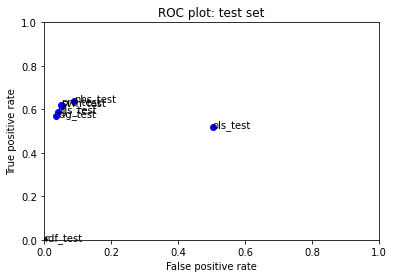

In [58]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [59]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_test.csv', my_random_seed=95, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 65536)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  exclaim_count
0          72          10              0
1          13           1              0
2          16           0              0
3          38           3              0
4           7           

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [60]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.503773732730929


In [61]:
raw_data.head()

,id,comment_text,word_count,punc_count,exclaim_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [62]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,False
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,True
4,00017695ad8997eb,False


In [63]:
my_submission.shape

(153164, 2)

In [64]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('/Users/isabelstoddart/Desktop/ML/myWork/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation